In [1]:
# #IMPORTS
import numpy as np
from matplotlib import pyplot as plt
import sys, os, time, pandas, scipy, sklearn
!pip install GPy
!pip install pods
import GPy
import pods
import numpy as np
import pandas as pd
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib as mpl#;mlp.rcParams['figure.figsize'] = (8,6)
from matplotlib import pyplot as plt
import sklearn
from sklearn import mixture
import itertools
import scipy
from scipy import linalg
from scipy.stats import multivariate_normal
from sklearn.cluster import KMeans
import time
from scipy.optimize import minimize
from scipy import optimize

     |████████████████████████████████| 959 kB 5.2 MB/s 
     |████████████████████████████████| 71 kB 7.1 MB/s 
  Created wheel for GPy: filename=GPy-1.10.0-cp37-cp37m-linux_x86_64.whl size=2565120 sha256=e6ab4244d279ff24b3d000d029801be1f5c47903488881da4b6aac204eafb11b
  Stored in directory: /root/.cache/pip/wheels/f7/18/28/dd1ce0192a81b71a3b086fd952511d088b21e8359ea496860a
  Created wheel for paramz: filename=paramz-0.9.5-py3-none-any.whl size=102565 sha256=8d03662d03bff241b29bc026c117c823d4fdf5727956395dfbedff3c090281e1
  Stored in directory: /root/.cache/pip/wheels/c8/95/f5/ce28482da28162e6028c4b3a32c41d147395825b3cd62bc810
Successfully built GPy paramz
     |████████████████████████████████| 55 kB 2.3 MB/s 


In [2]:
def varray(x):
    return x.reshape(x.shape[0], 1)
def varrayrow(x):
    return varray(x).transpose()
def enlarge(liml, limu, alphal, alphau='none'):
    if alphau=='none':
        alphau=alphal
    #This function
    aux1 = (1+alphal)/2
    aux2 = (1-alphal)/2
    aux3 = (1+alphau)/2
    aux4 = (1-alphau)/2
    return np.array((+ limu*aux2 + liml*aux1,limu*aux3 + liml*aux4))

In [3]:
class ucb():
    def __init__(self, X, R, verbose):
        self.X = X
        self.R = R
        self.kernel = GPy.kern.RBF(input_dim=self.X.shape[1], ARD=True)
        self.modelR = GPy.models.GPRegression( X=self.X, Y=self.R, kernel=self.kernel)
        self.verbose = verbose

    def operate_model(self, verbose=True):
        self.modelR.optimize(messages=verbose)
        if verbose:
            print(self.modelR.rbf.lengthscale)
        self.af = acquisition_function(model=self.modelR)
    
    def af_settings(self):
        if self.verbose:
            print ('self.af.lb', self.af.lb, 'self.af.ub', self.af.ub,
                   'self.af.kconst', self.af.kconst,'self.af.center', self.af.center)
    def operate_af(self, ploton=False):
        self.af.operate()
        if self.verbose:
            print ('self.af.res.x', self.af.res.x)
            print ('predicted reward', -self.af.func(self.af.res.x))

        # Avoid 0-dim array if dim=1
        try:
            xl = len(self.af.res.x)
        except:
            self.af.res.x = np.array([self.af.res.x])
                        
        self.rnew =np.ones(1)*(np.sin(self.af.res.x[0])/2 + np.cos((self.af.res.x[0]-1)*5))#include function here with the real reward related to self.af.res.x
        if self.verbose:
            print('real reward', self.rnew)
        
        self.X = np.concatenate((self.X, varrayrow(self.af.res.x)))
        self.R = np.concatenate([self.R, varrayrow(self.rnew)])
        self.modelR = GPy.models.GPRegression( X=self.X, Y=self.R, kernel=self.kernel.copy())

In [4]:
class acquisition_function():
    def __init__(self, model, kconst=1.):
        self.model = model
        self.ldim = self.model.X.shape[1]
        self.x_init = np.zeros(self.ldim).reshape(1,self.ldim)
        self.lb = np.ones(self.ldim)
        self.ub = np.ones(self.ldim)
        self.center = np.zeros(self.ldim)
        self.x = self.x_init.copy()
        self.kconst = kconst
    
    def func(self, x):
        self.xx = x
        return  -(self.model.predict(self.xx.reshape(1,self.ldim))[0] + 1.*self.kconst*np.sqrt(
                  self.model.predict(self.xx.reshape(1,self.ldim))[1] ))[0][0]#I had to add these [0][0], because now predict seems to be giving a strange array

        
    def operate(self):
        self.bounds = scipy.optimize.Bounds(self.center - self.lb, self.center+self.ub)
        self.res= minimize(self.func, self.x, bounds=self.bounds, method='Powell')     
    

In [5]:
Xdim = 1
X = np.zeros((1,Xdim))
R = (np.ones((1,1))*np.sin(0)/2 + np.cos((-1)*5)) #include here the real reward of one sampled point
ucb1 = ucb(X,R,False)
ucb1.modelR.rbf.lengthscale = .001

Nsamples = 16

 /usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning:Method Powell cannot handle constraints nor bounds.
 /usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning:Method Powell cannot handle constraints nor bounds.
 /usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning:Method Powell cannot handle constraints nor bounds.
 /usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning:Method Powell cannot handle constraints nor bounds.
 /usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning:Method Powell cannot handle constraints nor bounds.
 /usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning:Method Powell cannot handle constraints nor bounds.
 /usr/local/lib/python3.7/dist-packages/scipy/optimize/_minimize.py:522: RuntimeWarning:Method Powell cannot handle constraints nor bounds.
 /usr/local/lib/pyth

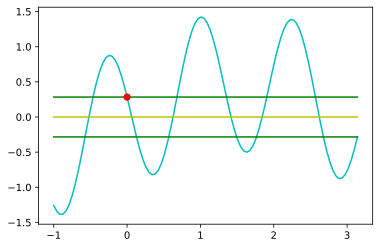

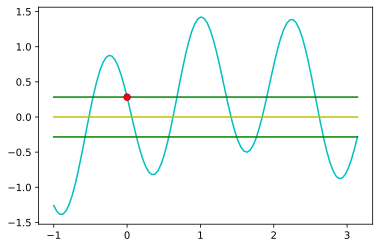

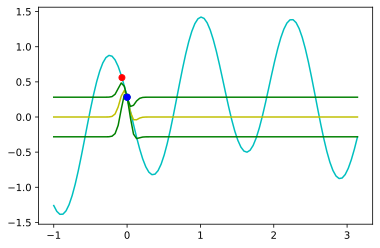

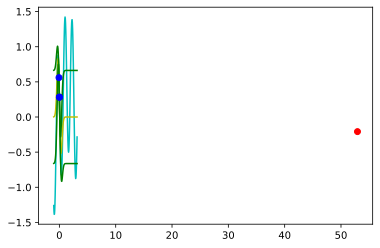

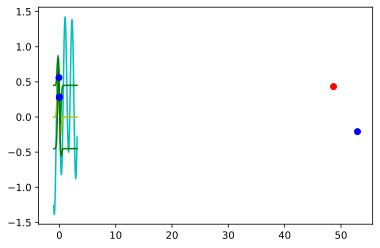

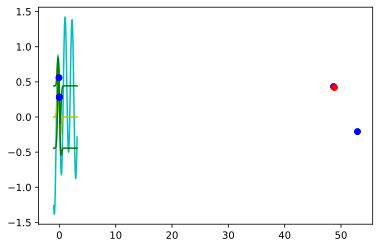

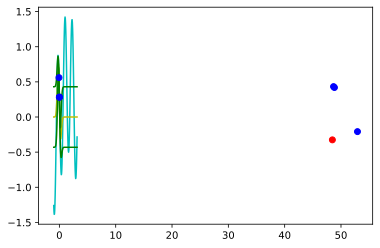

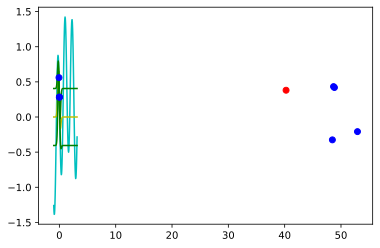

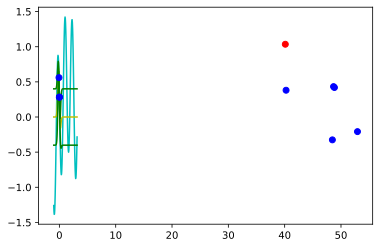

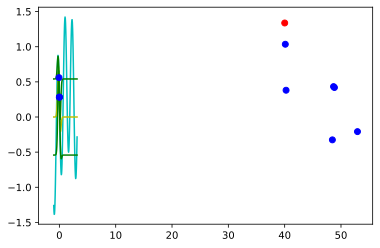

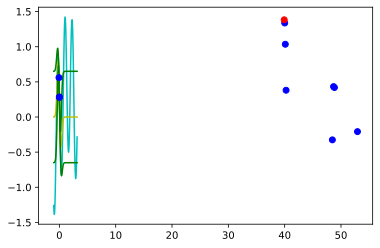

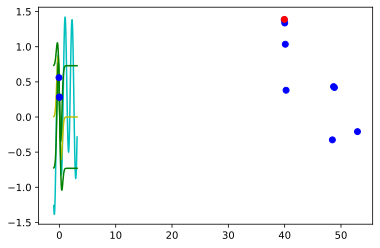

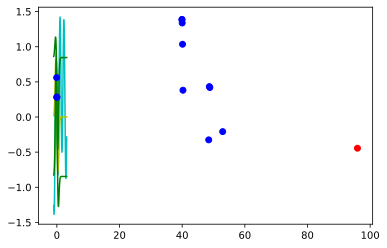

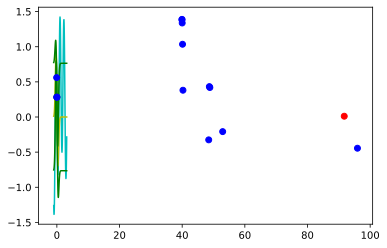

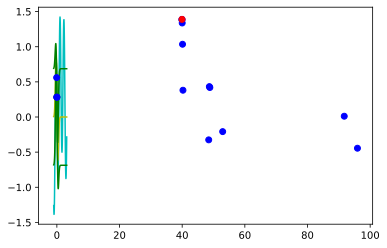

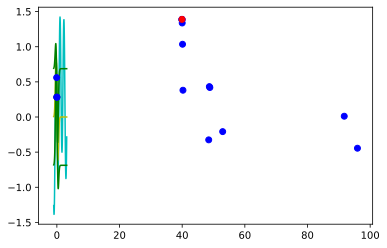

In [6]:
for i in range(0,Nsamples):
    ucb1.operate_model(False)
    ucb1.af.ub = np.ones(3) *np.pi
    #ucb1.af.lb[0] = np.pi*2
    ucb1.af.kconst = 1.
    ucb1.operate_af(ploton=False)
    
    plt.figure()
    XX = np.linspace(-ucb1.af.lb[0],ucb1.af.ub[0],100)
    RR =  (np.sin(XX[:])/2 + np.cos((XX[:]-1)*5))
    VV = ucb1.af.model.predict(varray(XX))


    plt.plot(XX, RR, 'c-' )
    plt.plot(XX, VV[0], 'y-' )
    plt.plot(XX, VV[0] + ucb1.af.kconst*np.sqrt(VV[1] ), 'g-' )
    plt.plot(XX, VV[0] - ucb1.af.kconst*np.sqrt(VV[1] ), 'g-' )


    plt.plot(ucb1.X[0:1,0], ucb1.R[0:1], 'go')
    plt.plot(ucb1.X[1:-1,0], ucb1.R[1:-1], 'bo')
    plt.plot(ucb1.X[-1,0], ucb1.R[-1:], 'ro')